In [1]:
import glob
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms
import cv2
from torch.utils.data import Dataset, DataLoader

# Make objects with the images and masks. 
brain_scans = []
mask_files = glob.glob('kaggle_3m/*/*_mask*')

for i in mask_files:
    brain_scans.append(i.replace('_mask',''))

In [2]:
# Make a dataframe with the images and their corresponding masks
data_df = pd.DataFrame({"image_path":brain_scans, "mask_path":mask_files})

In [3]:
import cv2
# Make a function that search for the largest pixel value in the masks, because that will indicate if the image have 
# a corresponding mask with a tumor or not. 
def positive_negative_diagnosis(file_masks):
    mask = cv2.imread(file_masks)
    value = np.max(mask)
    if value > 0:
        return 0
    else:
        return 1

In [4]:
# Apply the function to the masks and return back a column with 1 and zeros, where 0 indicate no tumor and 1 a tumor. 
data_df["tumour"] = data_df["mask_path"].apply(lambda x: positive_negative_diagnosis(x)) 

In [5]:
# Create the data sets
from sklearn.model_selection import train_test_split

train_df, test_df  = train_test_split(data_df, test_size = 0.1, stratify = data_df['tumour'] )
train_df, valid_df = train_test_split(train_df,test_size = 0.2, stratify = train_df['tumour'])

In [6]:
train_df.head()

image_path  \
637   kaggle_3m\TCGA_DU_5872_19950223\TCGA_DU_5872_1...   
1047  kaggle_3m\TCGA_DU_6408_19860521\TCGA_DU_6408_1...   
1933  kaggle_3m\TCGA_DU_8167_19970402\TCGA_DU_8167_1...   
2870  kaggle_3m\TCGA_FG_A60K_20040224\TCGA_FG_A60K_2...   
3695  kaggle_3m\TCGA_HT_A5RC_19990831\TCGA_HT_A5RC_1...   

                                              mask_path  tumour  
637   kaggle_3m\TCGA_DU_5872_19950223\TCGA_DU_5872_1...       0  
1047  kaggle_3m\TCGA_DU_6408_19860521\TCGA_DU_6408_1...       1  
1933  kaggle_3m\TCGA_DU_8167_19970402\TCGA_DU_8167_1...       1  
2870  kaggle_3m\TCGA_FG_A60K_20040224\TCGA_FG_A60K_2...       1  
3695  kaggle_3m\TCGA_HT_A5RC_19990831\TCGA_HT_A5RC_1...       1

little data cloud:

Number of training images: 2828
Number of validation images: 708
Number of test images: 393
Diagnosis distribution in training set:
tumour
1    1839
0     989
Name: count, dtype: int64


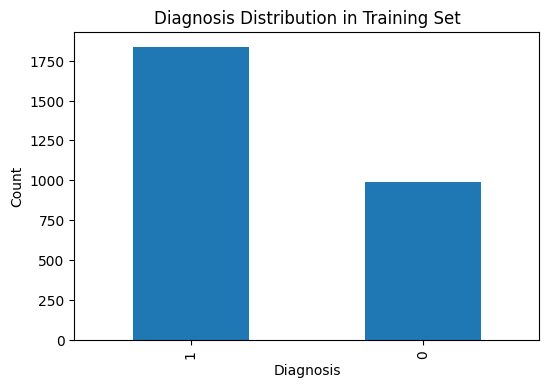

In [7]:
import matplotlib.pyplot as plt

# number of images
num_train_images = len(train_df)
num_val_images = len(valid_df)
num_test_images = len(test_df)

print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_val_images}")
print(f"Number of test images: {num_test_images}")

# distribution of diagnoses in training set
diagnosis_counts = train_df['tumour'].value_counts()
print("Diagnosis distribution in training set:")
print(diagnosis_counts)

# Plotting the distribution
plt.figure(figsize=(6, 4))
diagnosis_counts.plot(kind='bar')
plt.title('Diagnosis Distribution in Training Set')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()


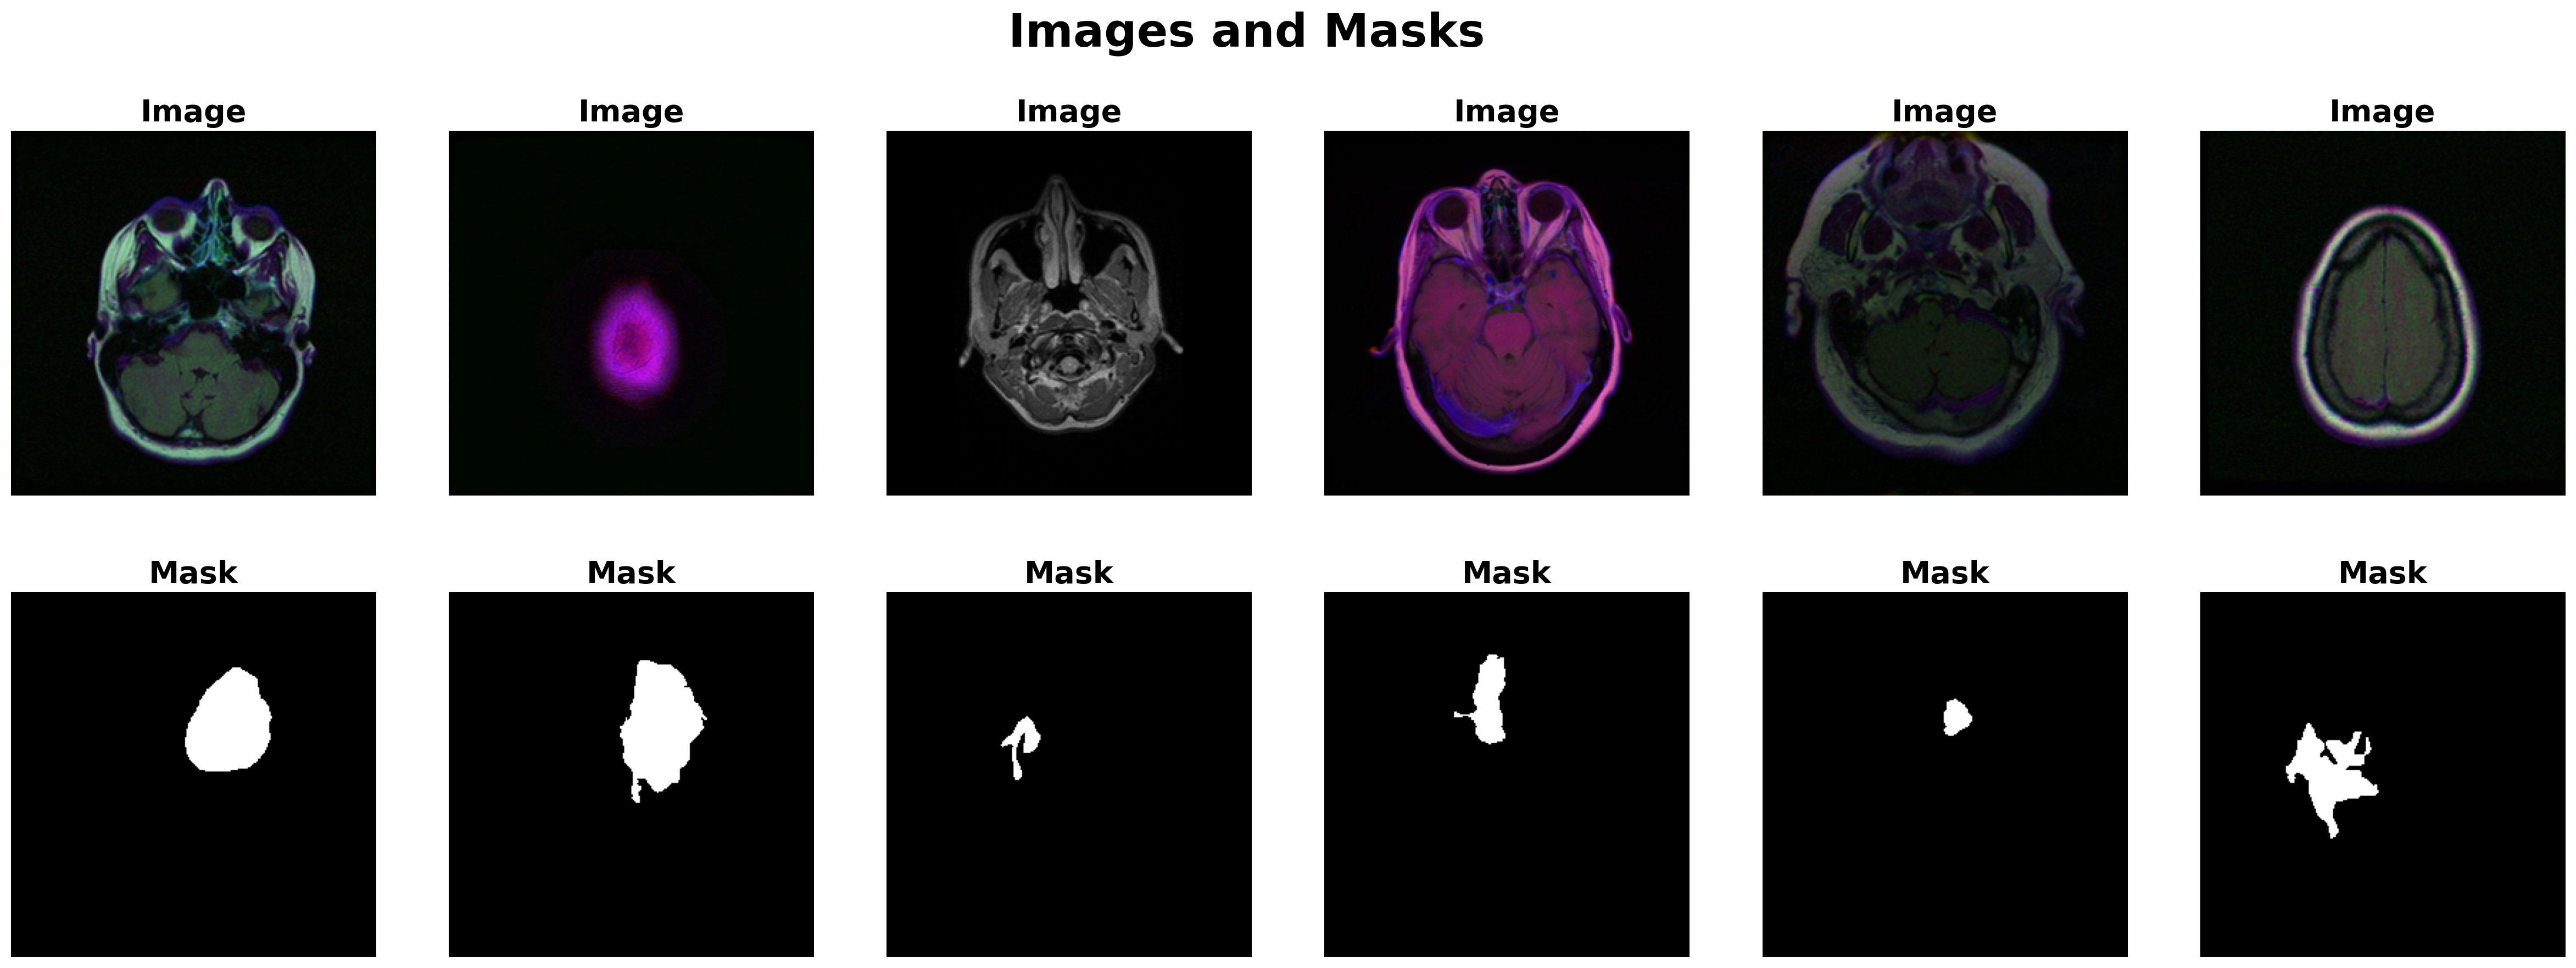

In [8]:
import matplotlib.pyplot as plt
from PIL import Image

def plot_images_and_masks(images, masks, predictions=None, IoU_list=None):
    num_samples = len(images)
    # Checking whether the function has been given the prediction array or not
    num_rows = 2 if type(predictions) == type(None) else 3
    
    # Defining figure
    fig, axes = plt.subplots(num_rows, num_samples,
                             figsize=(num_samples*5, num_samples+(num_rows*2)), dpi=200)
    
    for i in range(num_samples):
        # Plotting image
        axes[0, i].imshow(Image.open(images[i]), cmap='gray')
        axes[0, i].set_title('Image', fontsize=20, fontweight='bold')
        axes[0, i].axis('off')
        
        # Plotting mask
        axes[1, i].imshow(Image.open(masks[i]), cmap='gray')
        axes[1, i].set_title('Mask', fontsize=20, fontweight='bold')
        axes[1, i].axis('off')
        
        # Plotting prediction
        if type(predictions) != type(None):
            axes[2, i].imshow(predictions[i], cmap='gray')
            axes[2, i].set_title(f'Prediction | IoU: {round(float(IoU_list[i]), 3)}',
                                 fontsize=19, fontweight='bold')
            axes[2, i].axis('off')
             
    # Adding title
    plt.suptitle('Images and Masks', fontsize=30, fontweight='bold')
    
    # Showing the figure
    plt.show()

plot_images_and_masks(train_df[train_df['tumour'] == 1]['image_path'].values[:6],
                      train_df[train_df['tumour'] == 0]['mask_path'].values[:6])

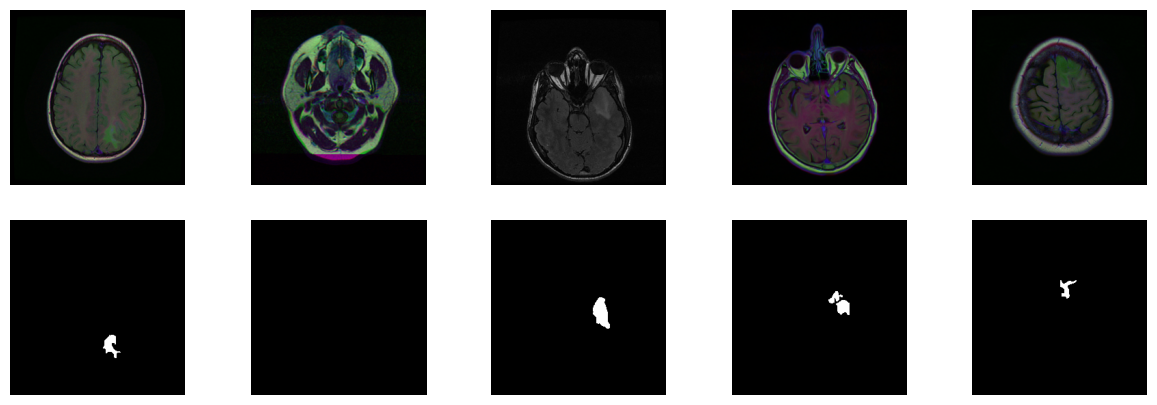

In [9]:
import random

def show_random_images(df, num_images=5):
    plt.figure(figsize=(15, 5))
    random_images = df.sample(num_images)
    for i, row in enumerate(random_images.itertuples()):
        image = Image.open(row.image_path)
        mask = Image.open(row.mask_path)
        plt.subplot(2, num_images, i + 1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(mask, cmap='gray')
        plt.axis('off')
    plt.show()

show_random_images(train_df)

In [10]:
print(len(train_df), len(valid_df), len(test_df))
IMAGE_SIZE = (256, 256)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(train_df.head())

def tensor_from_path(path):
    arr = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    arr = cv2.resize(arr, IMAGE_SIZE)
    arr = arr / 255
    if len(arr.shape) == 3:
        tensor = torch.tensor(arr).permute(2,0,1)
    elif len(arr.shape) == 2:
        tensor = torch.tensor(arr).unsqueeze(0)
    else:
        raise ValueError(f"Expected data shape to be (..., ..., 3) or (..., ...) , but got {arr.shape}")
    return tensor

class data(Dataset):
    def __init__(self, df):
        super().__init__()
        self.df = df        
        self.images = self.df.loc[:,'image_path'].values
        self.masks = self.df.loc[:,'mask_path'].values
        self.diagnosis = self.df.loc[:,'tumour'].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        im_path = self.images[idx]
        msk_path= self.masks[idx]
        diagnosis = self.diagnosis[idx]
        self.im_tensor = tensor_from_path(im_path)
        self.msk_tensor= tensor_from_path(msk_path)
        return self.im_tensor.to(device), self.msk_tensor.to(device),diagnosis

train_ds = data(train_df)
test_ds = data(test_df)
val_ds = data(valid_df)

train_dl = DataLoader(train_ds, batch_size=32)
test_dl = DataLoader(test_ds, batch_size=32)
val_dl = DataLoader(val_ds, batch_size=32)

2828 708 393
                                             image_path  \
637   kaggle_3m\TCGA_DU_5872_19950223\TCGA_DU_5872_1...   
1047  kaggle_3m\TCGA_DU_6408_19860521\TCGA_DU_6408_1...   
1933  kaggle_3m\TCGA_DU_8167_19970402\TCGA_DU_8167_1...   
2870  kaggle_3m\TCGA_FG_A60K_20040224\TCGA_FG_A60K_2...   
3695  kaggle_3m\TCGA_HT_A5RC_19990831\TCGA_HT_A5RC_1...   

                                              mask_path  tumour  
637   kaggle_3m\TCGA_DU_5872_19950223\TCGA_DU_5872_1...       0  
1047  kaggle_3m\TCGA_DU_6408_19860521\TCGA_DU_6408_1...       1  
1933  kaggle_3m\TCGA_DU_8167_19970402\TCGA_DU_8167_1...       1  
2870  kaggle_3m\TCGA_FG_A60K_20040224\TCGA_FG_A60K_2...       1  
3695  kaggle_3m\TCGA_HT_A5RC_19990831\TCGA_HT_A5RC_1...       1  


In [11]:
import torch
import torch.nn as nn

class BottleNeckBlock(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, downsample=None):
        super().__init__()

        base_width = 64
        width = int(out_channels * (base_width / 64.)) * 1

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=width, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=width)
        self.conv2 = nn.Conv2d(in_channels=width, out_channels=width, kernel_size=kernel_size, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=width)
        self.conv3 = nn.Conv2d(in_channels=width, out_channels=out_channels * self.expansion, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(num_features=out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        print(f"Input: {x.shape}")

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        print(f"After conv1: {out.shape}")

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        print(f"After conv2: {out.shape}")

        out = self.conv3(out)
        out = self.bn3(out)
        print(f"After conv3: {out.shape}")

        if self.downsample is not None:
            identity = self.downsample(x)
            print(f"Downsampled identity: {identity.shape}")

        out += identity
        out = self.relu(out)
        print(f"Output: {out.shape}")

        return out


In [12]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        print(out.shape())
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


In [13]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        print(x.shape())
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


In [14]:

resnet34 = ResNet(block=BasicBlock, layers=[3, 4, 6, 3], num_classes=1).to(device)

from torchinfo import summary
print(summary(resnet34, input_shape=(4, 3, 256, 256)))

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  4,096
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  4,096
│    │    └─BatchNorm2d: 3-5             128
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  36,864
│    │    └─BatchNorm2d: 3-7             128
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  36,864
│    │    └─BatchNorm2d: 3-10            128
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11                 36,864
│    │    └─BatchNorm2d: 3-12            128


In [15]:
'''

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

# Assuming the ResNet model is defined as resnet34

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Example hyperparameters
learning_rate = 0.001
batch_size = 32
num_epochs = 10

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.Adam(resnet34.parameters(), lr=learning_rate)

# Example DataLoader (replace with your own data loaders)
train_loader = train_dl
val_loader = val_dl

for batch in train_loader:
    print(len(batch))
    break  # Just to inspect the first batch

# Training loop
for epoch in range(num_epochs):
    resnet34.train()  # Set model to training mode
    train_loss = 0.0

    # Training
    for images, masks, _ in tqdm(train_loader):
        images = images.to(device).float()
        masks = masks.to(device).float()

        # Forward pass
        outputs = resnet34(images).squeeze(1)  # Remove extra dimension
        loss = criterion(outputs, masks.float())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

    # Validation loop
    resnet34.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = resnet34(images).squeeze(1)
            loss = criterion(outputs, masks.float())

            val_loss += loss.item()

            # Binary classification accuracy
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total += masks.size(0)
            correct += (predicted == masks).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    accuracy = 100 * correct / total

    print(f"Epoch [{epoch+1}/{num_epochs}], Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

'''

'\n\nimport torch\nimport torch.nn as nn\nimport torch.optim as optim\nfrom torch.utils.data import DataLoader\nfrom tqdm import tqdm\n\n# Assuming the ResNet model is defined as resnet34\n\n# Set up device\ndevice = torch.device(\'cuda\' if torch.cuda.is_available() else \'cpu\')\n\n# Example hyperparameters\nlearning_rate = 0.001\nbatch_size = 32\nnum_epochs = 10\n\n# Loss function\ncriterion = nn.BCEWithLogitsLoss()\n\n# Optimizer\noptimizer = optim.Adam(resnet34.parameters(), lr=learning_rate)\n\n# Example DataLoader (replace with your own data loaders)\ntrain_loader = train_dl\nval_loader = val_dl\n\nfor batch in train_loader:\n    print(len(batch))\n    break  # Just to inspect the first batch\n\n# Training loop\nfor epoch in range(num_epochs):\n    resnet34.train()  # Set model to training mode\n    train_loss = 0.0\n\n    # Training\n    for images, masks, _ in tqdm(train_loader):\n        images = images.to(device).float()\n        masks = masks.to(device).float()\n\n        #

In [16]:
!pip install torch torchvision



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
'''
import torch
import torch.nn as nn
import torchvision.models as models


# Load pre-trained ResNet-18 model
resnet = models.resnet18(pretrained=True)

# Modify the ResNet model for segmentation
class ResNetSegmentation(nn.Module):
    def __init__(self, original_model):
        super(ResNetSegmentation, self).__init__()
        self.features = nn.Sequential(
            original_model.conv1,
            original_model.bn1,
            original_model.relu,
            original_model.maxpool,
            original_model.layer1,
            original_model.layer2,
            original_model.layer3,
            original_model.layer4,
        )
        self.final_conv = nn.Conv2d(512, 1, kernel_size=1)  # 512 is the number of channels before the fc layer
        self.upsample = nn.Upsample(scale_factor=32, mode='bilinear', align_corners=True)  # Adjust scale_factor as needed

    def forward(self, x):
        x = self.features(x)  # Get feature maps
        x = self.final_conv(x)  # Apply the final convolution to output the segmentation map
        x = self.upsample(x)  # Upsample the output to match the input image size
        x = x.unsqueeze(1)  # Add channel dimension (if missing) to match target shape
        return x

# Instantiate the modified ResNet model for segmentation
resnet_segmentation = ResNetSegmentation(resnet)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_segmentation = resnet_segmentation.to(device)

# Example: Check the modified model structure
print(resnet_segmentation)







import torch.optim as optim
import torch.nn.functional as F
from tqdm.notebook import tqdm, trange

# Example DataLoader (replace with your actual DataLoader)
train_loader = train_dl
val_loader = val_dl

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # For binary segmentation
optimizer = optim.Adam(resnet_segmentation.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in trange(num_epochs):
    resnet_segmentation.train()  # Set model to training mode
    running_loss = 0.0
    correct_pixels = 0
    total_pixels = 0

    for i, (images, masks, _) in enumerate(tqdm(train_loader)):
        images = images.to(device).float()
        masks = masks.to(device).float()

        optimizer.zero_grad()
        outputs = resnet_segmentation(images)
        outputs = outputs.squeeze(1)  # Adjust output shape if necessary

        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate per-pixel accuracy
        predicted = torch.round(torch.sigmoid(outputs))
        correct_pixels += (predicted == masks).sum().item()
        total_pixels += masks.numel()

        if i % 100 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Step {i}/{len(train_loader)}, '
                  f'Current accuracy: {100 * correct_pixels / total_pixels:.2f}%, '
                  f'Running loss: {running_loss / (i + 1):.4f}')
            correct_pixels = 0
            total_pixels = 0

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

    # Validation
    resnet_segmentation.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        correct_pixels = 0
        total_pixels = 0

        for images, masks, _ in tqdm(val_loader):
            images = images.to(device).float()
            masks = masks.to(device).float()
            outputs = resnet_segmentation(images)
            outputs = outputs.squeeze(1)  # Adjust output shape if necessary

            loss = criterion(outputs, masks)
            val_loss += loss.item()

            # Calculate per-pixel accuracy
            predicted = torch.round(torch.sigmoid(outputs))
            correct_pixels += (predicted == masks).sum().item()
            total_pixels += masks.numel()

    print(f"Validation Loss: {val_loss / len(val_loader):.4f}, "
          f"Validation Accuracy: {100 * correct_pixels / total_pixels:.2f}%")

print("Training completed!")


'''

'\nimport torch\nimport torch.nn as nn\nimport torchvision.models as models\n\n\n# Load pre-trained ResNet-18 model\nresnet = models.resnet18(pretrained=True)\n\n# Modify the ResNet model for segmentation\nclass ResNetSegmentation(nn.Module):\n    def __init__(self, original_model):\n        super(ResNetSegmentation, self).__init__()\n        self.features = nn.Sequential(\n            original_model.conv1,\n            original_model.bn1,\n            original_model.relu,\n            original_model.maxpool,\n            original_model.layer1,\n            original_model.layer2,\n            original_model.layer3,\n            original_model.layer4,\n        )\n        self.final_conv = nn.Conv2d(512, 1, kernel_size=1)  # 512 is the number of channels before the fc layer\n        self.upsample = nn.Upsample(scale_factor=32, mode=\'bilinear\', align_corners=True)  # Adjust scale_factor as needed\n\n    def forward(self, x):\n        x = self.features(x)  # Get feature maps\n        x =

resNet model from torch!

In [18]:
import torch
import torch.nn as nn
import torchvision.models as models
# pre-trained ResNet model
resnet = models.resnet18(pretrained=True)

# Modify the last layer for binary classification
num_classes = 1  
resnet.fc = nn.Sequential(
    nn.Linear(resnet.fc.in_features, num_classes),
    nn.Sigmoid()  # Sigmoid activation for binary classification
)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)

c:\Users\roee hilel\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\roee hilel\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

resNet training:

In [20]:
import torch.optim as optim
import torch.nn.functional as F
from tqdm.notebook import tqdm, trange


# Example DataLoader (replace with your actual DataLoader)
train_loader = train_dl
val_loader = val_dl

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # For binary segmentation
optimizer = optim.Adam(resnet.parameters(), lr=0.001)


dataloader = torch.utils.data.DataLoader(train_ds, batch_size=4, shuffle=True)

# Training loop
num_epochs = 8
for epoch in trange(num_epochs):
    resnet.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, _, labels) in enumerate(tqdm(train_loader)):
        images = images.to(device).float()
        labels = labels.to(device).float()

        optimizer.zero_grad()
        outputs = resnet(images).squeeze()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        predicted = torch.round(outputs.data)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 40 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Step {i}/{len(train_loader)}, '
                  f'Current accuracy: {100 * correct / total:.2f}%, '
                  f'Running loss: {running_loss / (i + 1):.4f}')
            correct = 0
            total = 0

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

    # Validation
    resnet.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, _, labels in tqdm(val_loader):
            images = images.to(device).float()
            labels = labels.to(device).float()
            outputs = resnet(images).squeeze()

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = torch.round(outputs.data)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    print(f"Validation Loss: {val_loss / len(val_loader):.4f}, "
          f"Validation Accuracy: {100 * val_correct / val_total:.2f}%")

print("Training completed!")


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 1/8, Step 0/89, Current accuracy: 31.25%, Running loss: 0.6496
Epoch 1/8, Step 40/89, Current accuracy: 76.72%, Running loss: 0.5568
Epoch 1/8, Step 80/89, Current accuracy: 78.67%, Running loss: 0.5476
Epoch [1/8], Loss: 0.5471


  0%|          | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.5340, Validation Accuracy: 79.24%


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 2/8, Step 0/89, Current accuracy: 71.88%, Running loss: 0.5446
Epoch 2/8, Step 40/89, Current accuracy: 80.86%, Running loss: 0.5393
Epoch 2/8, Step 80/89, Current accuracy: 78.67%, Running loss: 0.5383
Epoch [2/8], Loss: 0.5366


  0%|          | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.5494, Validation Accuracy: 75.00%


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 3/8, Step 0/89, Current accuracy: 81.25%, Running loss: 0.5142
Epoch 3/8, Step 40/89, Current accuracy: 82.97%, Running loss: 0.5292
Epoch 3/8, Step 80/89, Current accuracy: 82.97%, Running loss: 0.5250
Epoch [3/8], Loss: 0.5246


  0%|          | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.5250, Validation Accuracy: 86.30%


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 4/8, Step 0/89, Current accuracy: 90.62%, Running loss: 0.4809
Epoch 4/8, Step 40/89, Current accuracy: 85.47%, Running loss: 0.5198
Epoch 4/8, Step 80/89, Current accuracy: 88.59%, Running loss: 0.5116
Epoch [4/8], Loss: 0.5107


  0%|          | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.5322, Validation Accuracy: 84.04%


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 5/8, Step 0/89, Current accuracy: 90.62%, Running loss: 0.4665
Epoch 5/8, Step 40/89, Current accuracy: 88.59%, Running loss: 0.5049
Epoch 5/8, Step 80/89, Current accuracy: 88.75%, Running loss: 0.5014
Epoch [5/8], Loss: 0.5013


  0%|          | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.5225, Validation Accuracy: 80.37%


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 6/8, Step 0/89, Current accuracy: 84.38%, Running loss: 0.4893
Epoch 6/8, Step 40/89, Current accuracy: 87.34%, Running loss: 0.5125
Epoch 6/8, Step 80/89, Current accuracy: 89.77%, Running loss: 0.5028
Epoch [6/8], Loss: 0.5011


  0%|          | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.4879, Validation Accuracy: 89.97%


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 7/8, Step 0/89, Current accuracy: 96.88%, Running loss: 0.4513
Epoch 7/8, Step 40/89, Current accuracy: 90.86%, Running loss: 0.4942
Epoch 7/8, Step 80/89, Current accuracy: 90.00%, Running loss: 0.4926
Epoch [7/8], Loss: 0.4907


  0%|          | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.4782, Validation Accuracy: 93.64%


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 8/8, Step 0/89, Current accuracy: 100.00%, Running loss: 0.4405
Epoch 8/8, Step 40/89, Current accuracy: 93.91%, Running loss: 0.4818
Epoch 8/8, Step 80/89, Current accuracy: 92.11%, Running loss: 0.4822
Epoch [8/8], Loss: 0.4810


  0%|          | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.4855, Validation Accuracy: 90.11%
Training completed!


In [21]:
import torch
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import precision_score, recall_score

# Ensure model is in evaluation mode
resnet.eval()

# Prepare the test data loader
test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=4, shuffle=False)

correct = 0
total = 0
all_predicted = []
all_labels = []

with torch.no_grad():  # Disable gradient calculation
    for data in test_dataloader:
        images, _, labels = data
        images = images.float().to(device)
        labels = labels.float().to(device)
        
        # Get model outputs
        outputs = resnet(images).squeeze()
        
        # Apply threshold to get binary predictions
        predicted = (outputs.data > 0.1).int()  # Convert to int (0 or 1)
        
        # Flatten predicted and labels to ensure correct shapes
        predicted = predicted.view(-1)  # Flatten to 1D
        labels = labels.view(-1)        # Flatten to 1D

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = 100 * correct / total

# Calculate precision and recall
precision = precision_score(all_labels, all_predicted)
recall = recall_score(all_labels, all_predicted)

# Print the results
print('Accuracy of the network on the test images: %d %%' % accuracy)
print('Precision of the network on the test images: %f' % precision)
print('Recall of the network on the test images: %f' % recall)


Accuracy of the network on the test images: 92 %
Precision of the network on the test images: 0.978992
Recall of the network on the test images: 0.910156


grad cam of resnet:

For grad cam explaination 

https://github.com/jacobgil/pytorch-grad-cam

0.1721055507659912


100%|██████████| 16/16 [00:22<00:00,  1.42s/it]


22.84887981414795
0.15476441383361816


100%|██████████| 16/16 [00:22<00:00,  1.39s/it]


22.339888334274292
0.17986202239990234


100%|██████████| 16/16 [00:22<00:00,  1.41s/it]


22.627203702926636
0.15550446510314941


100%|██████████| 16/16 [00:22<00:00,  1.39s/it]


22.369327306747437


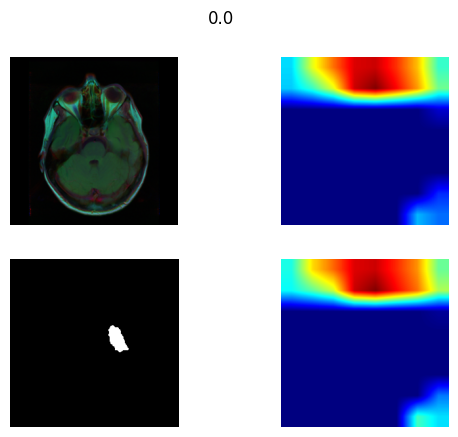

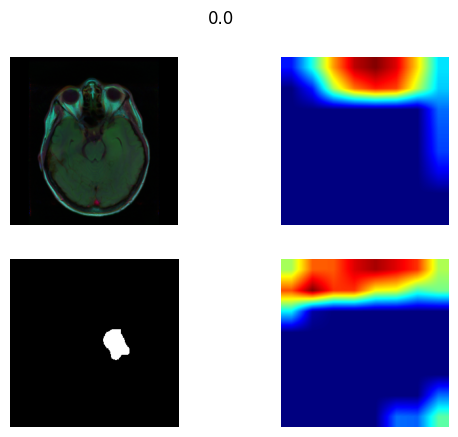

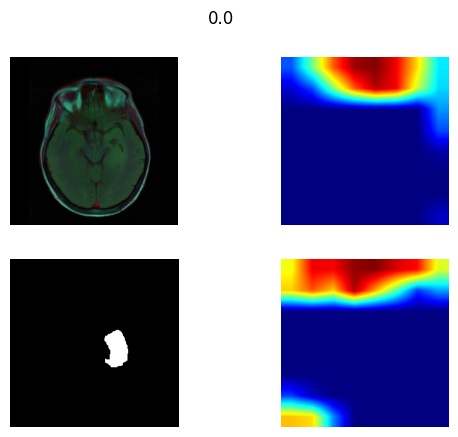

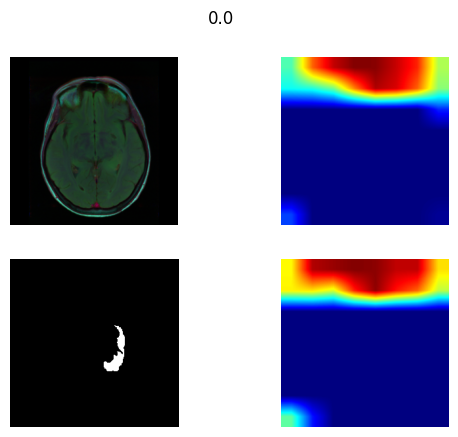

In [22]:
from pytorch_grad_cam import HiResCAM, EigenCAM,AblationCAM,XGradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import time

def visualize_prediction(path):
    target_layers = [resnet.layer4[1].conv2]
    input_tensor = tensor_from_path(path).float().to(device)
    input_tensor = input_tensor.unsqueeze(0)

    rgb_img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    rgb_img = cv2.resize(rgb_img, IMAGE_SIZE)
    rgb_img = np.array(rgb_img,dtype=np.float32)
    rgb_img /= 256

    fig,ax=plt.subplots(nrows=2,ncols=2)

    fig.suptitle(torch.round(resnet(input_tensor).squeeze()).cpu().detach().numpy())

    ax[0][0].axis('off')   
    ax[0][0].imshow(rgb_img)


    mask_img = cv2.imread(path.replace('.tif','_mask.tif'), cv2.IMREAD_UNCHANGED)
    mask_img = cv2.resize(mask_img, IMAGE_SIZE)

    ax[1][0].axis('off')   
    ax[1][0].imshow(mask_img,cmap='gray')

    i = 2
    methods = [XGradCAM,AblationCAM]

    for method in methods:
        start = time.time()
        cam = method(model=resnet, target_layers=target_layers)
        grayscale_cam = cam(input_tensor=input_tensor)
        grayscale_cam = grayscale_cam[0, :]
        end = time.time()
        print(end - start)

        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True,image_weight=0)

        ax[i%2][i//2].axis('off')
        ax[i%2][i//2].imshow(visualization)
        i+=1
        plt.plot()

visualize_prediction('kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_8.tif')
visualize_prediction('kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_9.tif')
visualize_prediction('kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_10.tif')
visualize_prediction('kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_11.tif')

ensamble learning of resNet and Efficient net:

efficient model:

In [23]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load pre-trained EfficientNet model
efficientnet = models.efficientnet_b0(pretrained=True)

# Modify the last layer for binary classification
num_classes = 1  
efficientnet.classifier[1] = nn.Sequential(
    nn.Linear(efficientnet.classifier[1].in_features, num_classes),
    nn.Sigmoid()  # Sigmoid activation for binary classification
)

# Move the model to the appropriate device
efficientnet = efficientnet.to(device)

# Print the EfficientNet model to verify the changes
print(efficientnet)


# pre-trained ResNet model
resnet2 = models.resnet18(pretrained=True)

# Modify the last layer for binary classification
num_classes = 1  
resnet2.fc = nn.Sequential(
    nn.Linear(resnet2.fc.in_features, num_classes),
    nn.Sigmoid()  # Sigmoid activation for binary classification
)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet2 = resnet.to(device)

c:\Users\roee hilel\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\roee hilel\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\roee hilel\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing 

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [24]:
class EnsembleModel(nn.Module):
    def __init__(self, modelA, modelB):
        super(EnsembleModel, self).__init__()
        self.modelA = modelA
        self.modelB = modelB

    def forward(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x)
        # Averaging the outputs from both models
        x = (x1 + x2) / 2
        return x

# Instantiate the ensemble model
ensemble_model = EnsembleModel(resnet2, efficientnet)
ensemble_model = ensemble_model.to(device)

# Print the ensemble model to verify
print(ensemble_model)


EnsembleModel(
  (modelA): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [25]:

# Loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(ensemble_model.parameters(), lr=0.001)

# Example DataLoader (replace with your actual DataLoader)
train_loader = train_dl
val_loader = val_dl

num_epochs = 8

for epoch in trange(num_epochs):
    ensemble_model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, _, labels) in enumerate(tqdm(train_loader)):
        images = images.to(device).float()
        labels = labels.to(device).float()

        optimizer.zero_grad()
        outputs = ensemble_model(images).squeeze()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        predicted = torch.round(outputs.data)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 40 == 0:
            print(f'Epoch {epoch + 1}/{num_epochs}, Step {i}/{len(train_loader)}, '
                  f'Current accuracy: {100 * correct / total:.2f}%, '
                  f'Running loss: {running_loss / (i + 1):.4f}')
            correct = 0
            total = 0

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

    # Validation
    ensemble_model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, _, labels in tqdm(val_loader):
            images = images.to(device).float()
            labels = labels.to(device).float()
            outputs = ensemble_model(images).squeeze()

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            predicted = torch.round(outputs.data)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    print(f"Validation Loss: {val_loss / len(val_loader):.4f}, "
          f"Validation Accuracy: {100 * val_correct / val_total:.2f}%")

print("Training completed!")


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 1/8, Step 0/89, Current accuracy: 96.88%, Running loss: 0.3290
Epoch 1/8, Step 40/89, Current accuracy: 90.39%, Running loss: 0.3022
Epoch 1/8, Step 80/89, Current accuracy: 93.36%, Running loss: 0.2549
Epoch [1/8], Loss: 0.2466


  0%|          | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.2260, Validation Accuracy: 90.96%


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 2/8, Step 0/89, Current accuracy: 93.75%, Running loss: 0.2348
Epoch 2/8, Step 40/89, Current accuracy: 92.58%, Running loss: 0.2072
Epoch 2/8, Step 80/89, Current accuracy: 94.06%, Running loss: 0.1867
Epoch [2/8], Loss: 0.1826


  0%|          | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.2041, Validation Accuracy: 87.99%


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 3/8, Step 0/89, Current accuracy: 96.88%, Running loss: 0.1301
Epoch 3/8, Step 40/89, Current accuracy: 94.84%, Running loss: 0.1364
Epoch 3/8, Step 80/89, Current accuracy: 96.17%, Running loss: 0.1263
Epoch [3/8], Loss: 0.1239


  0%|          | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.1381, Validation Accuracy: 95.76%


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 4/8, Step 0/89, Current accuracy: 93.75%, Running loss: 0.0704
Epoch 4/8, Step 40/89, Current accuracy: 96.48%, Running loss: 0.1153
Epoch 4/8, Step 80/89, Current accuracy: 94.84%, Running loss: 0.1175
Epoch [4/8], Loss: 0.1167


  0%|          | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.2407, Validation Accuracy: 85.59%


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 5/8, Step 0/89, Current accuracy: 100.00%, Running loss: 0.0942
Epoch 5/8, Step 40/89, Current accuracy: 96.25%, Running loss: 0.0947
Epoch 5/8, Step 80/89, Current accuracy: 96.56%, Running loss: 0.0993
Epoch [5/8], Loss: 0.0965


  0%|          | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.1971, Validation Accuracy: 94.63%


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 6/8, Step 0/89, Current accuracy: 96.88%, Running loss: 0.0518
Epoch 6/8, Step 40/89, Current accuracy: 96.80%, Running loss: 0.0881
Epoch 6/8, Step 80/89, Current accuracy: 97.27%, Running loss: 0.0884
Epoch [6/8], Loss: 0.0848


  0%|          | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.1310, Validation Accuracy: 94.77%


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 7/8, Step 0/89, Current accuracy: 100.00%, Running loss: 0.0113
Epoch 7/8, Step 40/89, Current accuracy: 96.72%, Running loss: 0.0804
Epoch 7/8, Step 80/89, Current accuracy: 97.89%, Running loss: 0.0735
Epoch [7/8], Loss: 0.0705


  0%|          | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.1270, Validation Accuracy: 95.62%


  0%|          | 0/89 [00:00<?, ?it/s]

Epoch 8/8, Step 0/89, Current accuracy: 100.00%, Running loss: 0.0466
Epoch 8/8, Step 40/89, Current accuracy: 97.66%, Running loss: 0.0762
Epoch 8/8, Step 80/89, Current accuracy: 97.97%, Running loss: 0.0641
Epoch [8/8], Loss: 0.0608


  0%|          | 0/23 [00:00<?, ?it/s]

Validation Loss: 0.1078, Validation Accuracy: 96.61%
Training completed!


In [26]:
# Saving the model
torch.save(ensemble_model.state_dict(), 'ensemble_model.pth')

# Loading the model
ensemble_model.load_state_dict(torch.load('ensemble_model.pth'))

<All keys matched successfully>

grad cam for ensamble:

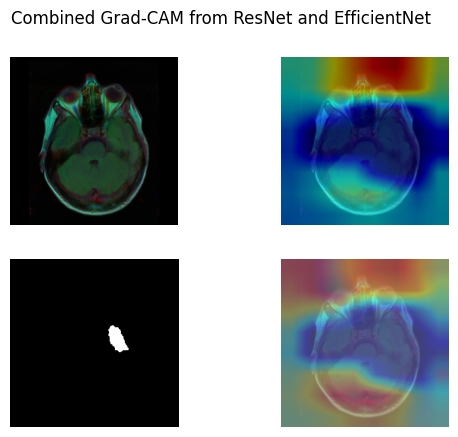

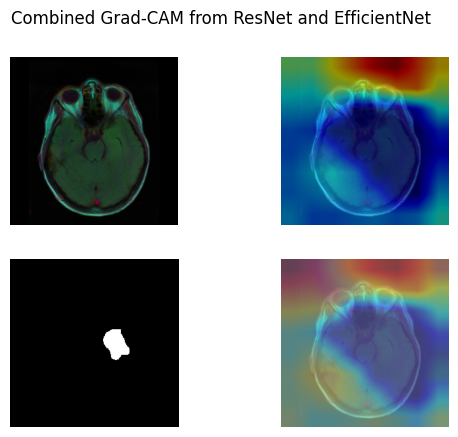

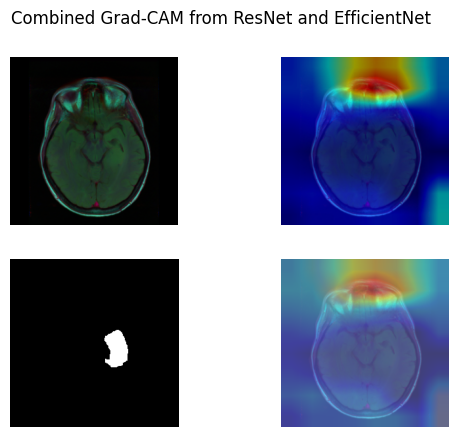

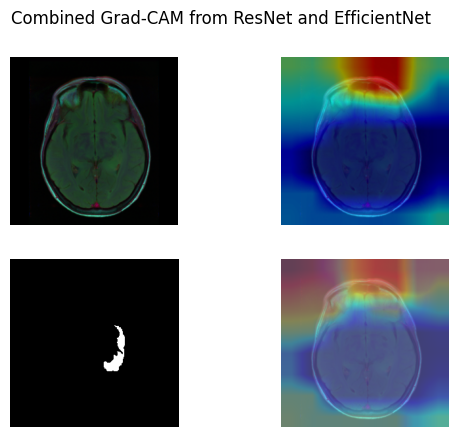

In [27]:
# Grad-CAM visualization function
def visualize_ensemble_gradcam(path, model_a = resnet2, model_b = efficientnet, target_layers_a = [resnet2.layer4[1].conv2]
                               , target_layers_b =[efficientnet.features[8][0]] ):
    input_tensor = tensor_from_path(path).float().to(device)
    input_tensor = input_tensor.unsqueeze(0)  # Add batch dimension

    # Load and prepare the original image
    rgb_img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    rgb_img = cv2.resize(rgb_img, IMAGE_SIZE)
    rgb_img = np.array(rgb_img, dtype=np.float32)
    rgb_img /= 255.0  # Normalize to [0, 1]

    fig, ax = plt.subplots(nrows=2, ncols=2)
    fig.suptitle("Combined Grad-CAM from ResNet and EfficientNet")

    # Display the original image
    ax[0][0].axis('off')
    ax[0][0].imshow(rgb_img)

    # Load and display the corresponding mask image (if available)
    mask_img = cv2.imread(path.replace('.tif', '_mask.tif'), cv2.IMREAD_UNCHANGED)
    if mask_img is not None:
        mask_img = cv2.resize(mask_img,IMAGE_SIZE)
        ax[1][0].axis('off')
        ax[1][0].imshow(mask_img, cmap='gray')

    # Apply Grad-CAM for ResNet
    cam_resnet = XGradCAM(model=model_a, target_layers=target_layers_a)
    grayscale_cam_resnet = cam_resnet(input_tensor=input_tensor)[0]

    # Apply Grad-CAM for EfficientNet
    cam_efficientnet = XGradCAM(model=model_b, target_layers=target_layers_b)
    grayscale_cam_efficientnet = cam_efficientnet(input_tensor=input_tensor)[0]

    # Combine CAMs by averaging
    combined_grayscale_cam = (grayscale_cam_resnet + grayscale_cam_efficientnet) / 2.0

    # Overlay combined CAM on the original image
    visualization_combined = show_cam_on_image(rgb_img, combined_grayscale_cam, use_rgb=True)

    # Display the visualization
    ax[0][1].axis('off')
    ax[0][1].imshow(visualization_combined)

    # Optionally display individual CAMs
    visualization_resnet = show_cam_on_image(rgb_img, grayscale_cam_resnet, use_rgb=True)
    visualization_efficientnet = show_cam_on_image(rgb_img, grayscale_cam_efficientnet, use_rgb=True)

    ax[1][1].axis('off')
    ax[1][1].imshow(visualization_resnet, alpha=0.5)
    ax[1][1].imshow(visualization_efficientnet, alpha=0.5)  # Combine with transparency

    plt.show()

# Define the target layers for Grad-CAM
target_layers_resnet = [resnet2.layer4[1].conv2]  # Last convolutional layer in ResNet
target_layers_efficientnet = [efficientnet.features[8][0]]  # Last convolutional layer in EfficientNet

# Example usage
visualize_ensemble_gradcam('kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_8.tif')
visualize_ensemble_gradcam('kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_9.tif')
visualize_ensemble_gradcam('kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_10.tif')
visualize_ensemble_gradcam('kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_11.tif')

In a wierd fashion, even if the classification is wrong, we still get a good heatmap of abnormalities

0.2305583953857422


100%|██████████| 16/16 [00:38<00:00,  2.39s/it]

38.43522810935974


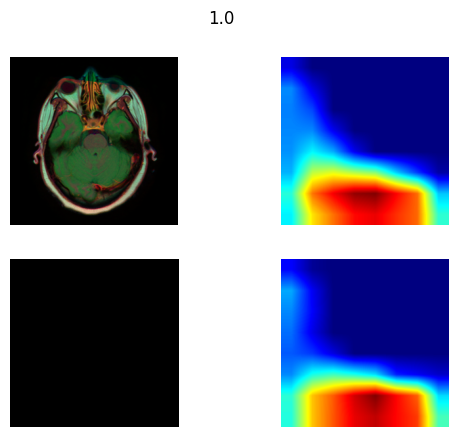

In [28]:
visualize_prediction('kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_11.tif')
#this case is no cancer


In [29]:
for i in range(1,32):
    visualize_prediction(f'kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_{i}.tif')

0.17825603485107422


100%|██████████| 16/16 [00:27<00:00,  1.75s/it]


28.111013412475586
0.1579270362854004


100%|██████████| 16/16 [00:34<00:00,  2.15s/it]


34.442115783691406
0.19525527954101562


100%|██████████| 16/16 [00:50<00:00,  3.18s/it]


51.03873682022095
0.28994059562683105


 69%|██████▉   | 11/16 [00:29<00:12,  2.50s/it]

0.03132915496826172


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


0.6939785480499268
0.0545954704284668


100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


0.8532800674438477
0.04360461235046387


100%|██████████| 1/1 [00:00<00:00,  1.14it/s]


0.942720890045166
0.10594677925109863


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]


0.7494592666625977
0.04974031448364258


100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


0.7416331768035889
0.0502469539642334


100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


0.8137509822845459
0.02811121940612793


100%|██████████| 1/1 [00:00<00:00,  1.94it/s]


0.5503039360046387
0.03126096725463867


100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


0.5342874526977539
0.1611630916595459


100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


0.5302355289459229
0.029405832290649414


100%|██████████| 1/1 [00:00<00:00,  1.79it/s]


0.6018710136413574
0.04856419563293457


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


0.622314453125
0.05043649673461914


100%|██████████| 1/1 [00:00<00:00,  1.71it/s]


0.6239402294158936
0.029177427291870117


100%|██████████| 1/1 [00:00<00:00,  1.87it/s]


0.5681066513061523
0.03321218490600586


100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


0.7128527164459229
0.030408620834350586


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


0.4831068515777588
0.028867721557617188


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


0.45284390449523926
0.035978078842163086


100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


0.4659559726715088
0.0312650203704834


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


0.47752857208251953
0.024724245071411133


100%|██████████| 1/1 [00:00<00:00,  2.02it/s]


0.535088062286377
0.047868967056274414


100%|██████████| 1/1 [00:00<00:00,  2.20it/s]
C:\Users\roee hilel\AppData\Local\Temp\ipykernel_19336\2484463701.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax=plt.subplots(nrows=2,ncols=2)


0.5022456645965576
0.030817508697509766


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


0.4857192039489746
0.04946017265319824


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


0.4798734188079834
0.025243759155273438


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


0.4217798709869385
0.023816823959350586


100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


0.43955063819885254
0.026352405548095703


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


0.4214954376220703


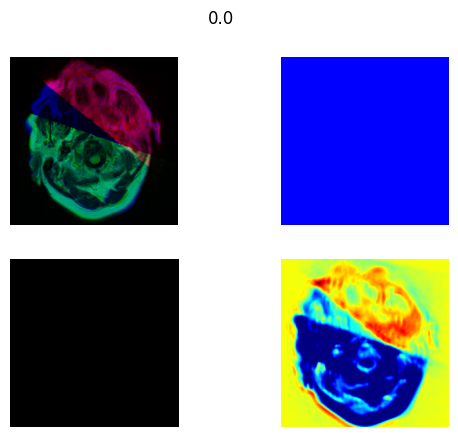

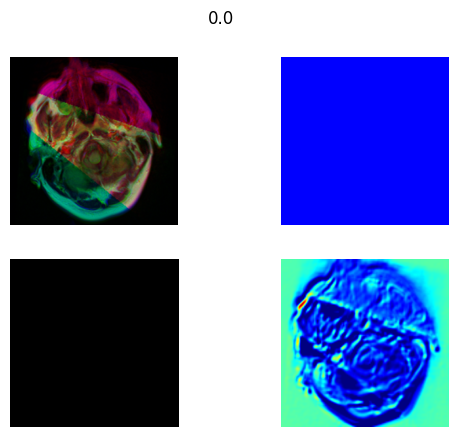

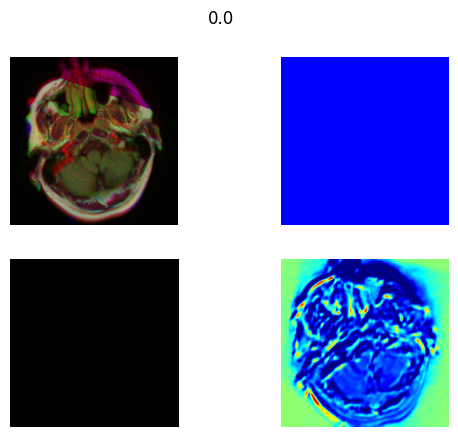

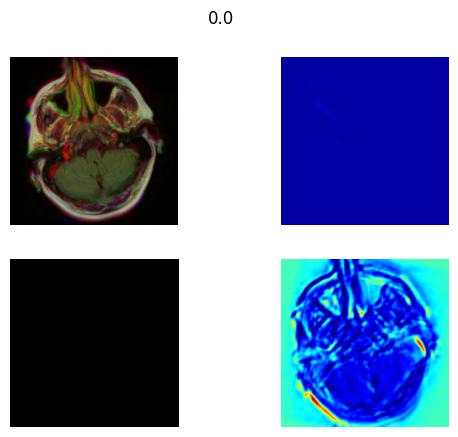

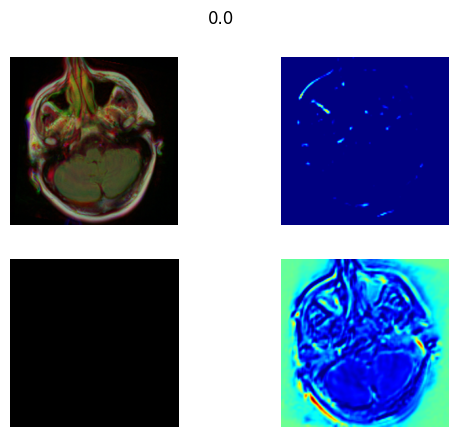

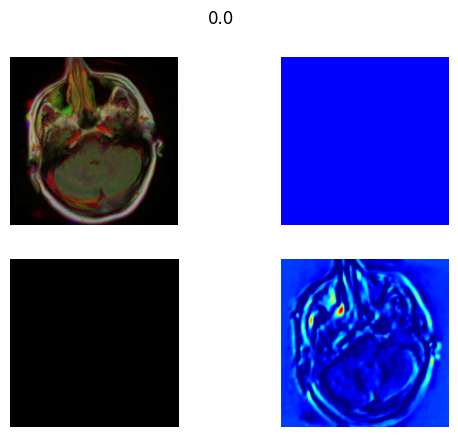

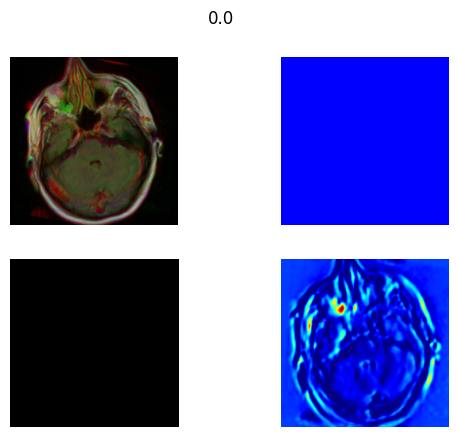

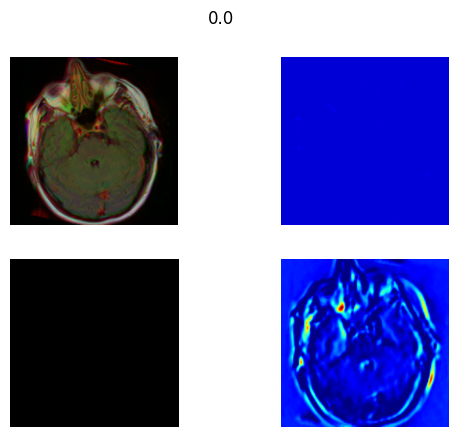

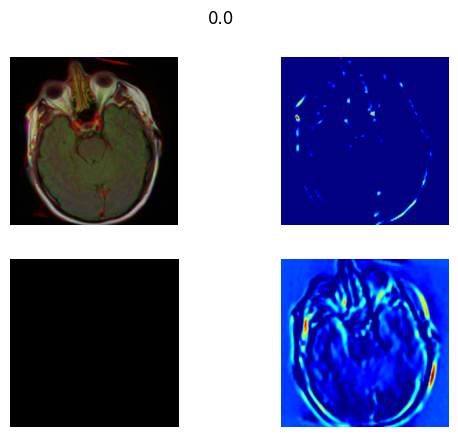

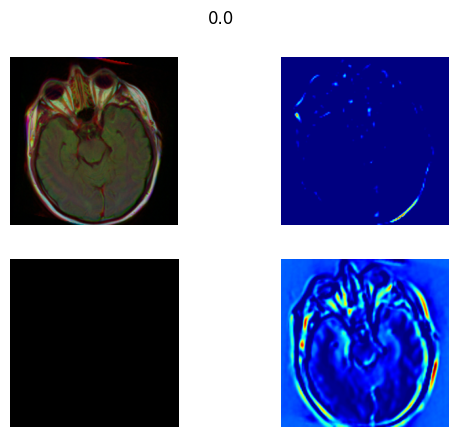

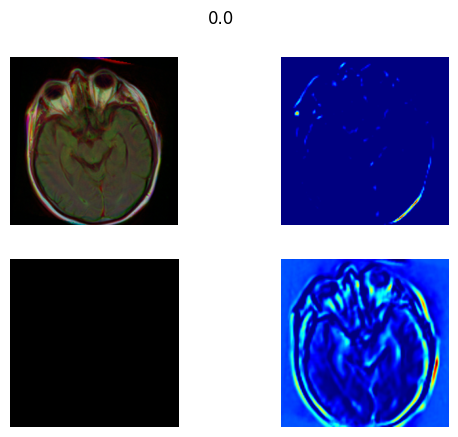

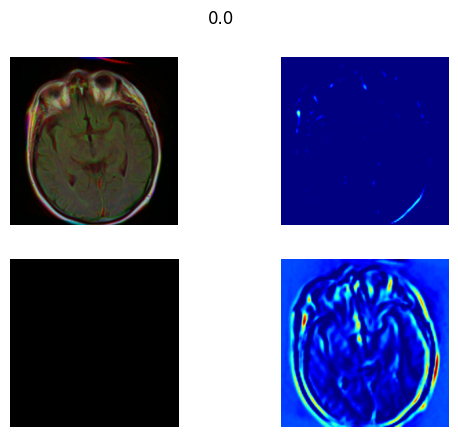

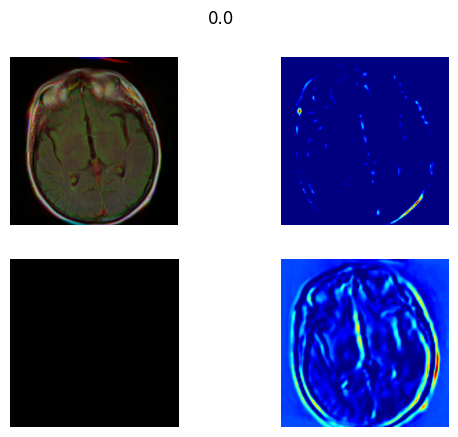

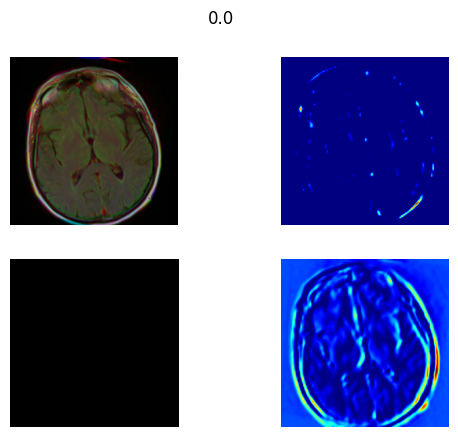

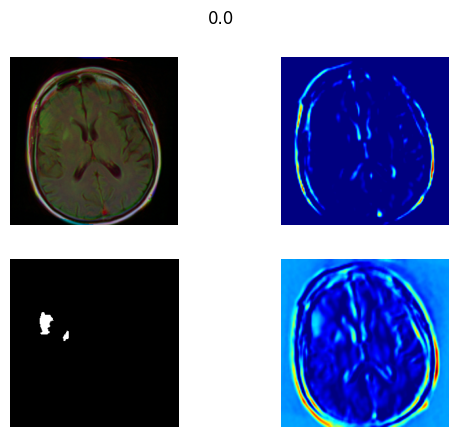

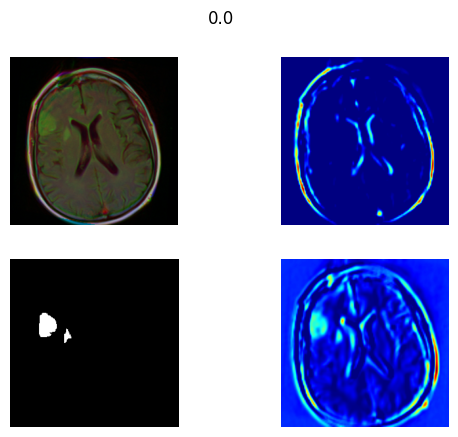

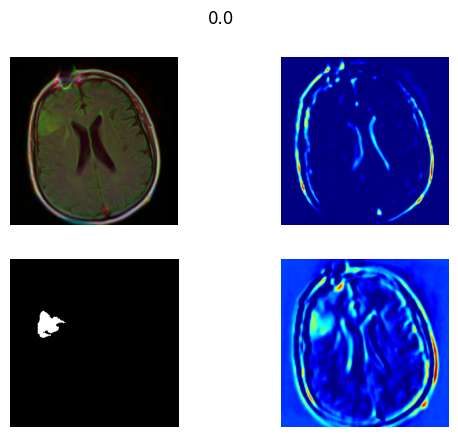

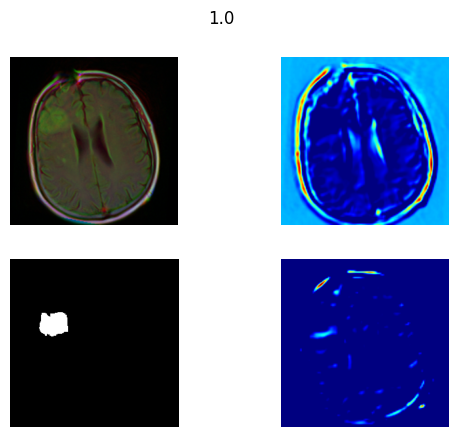

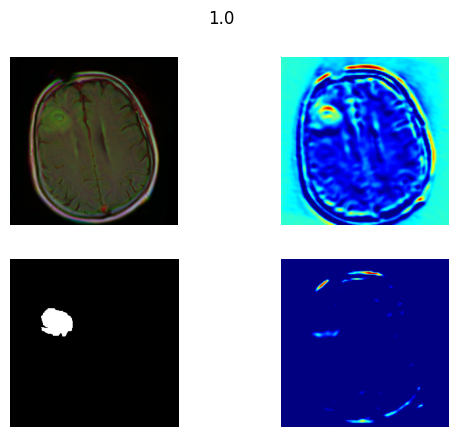

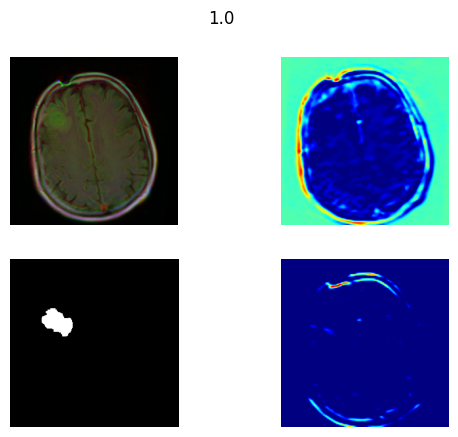

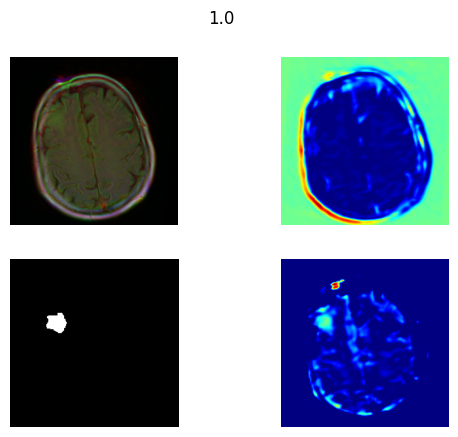

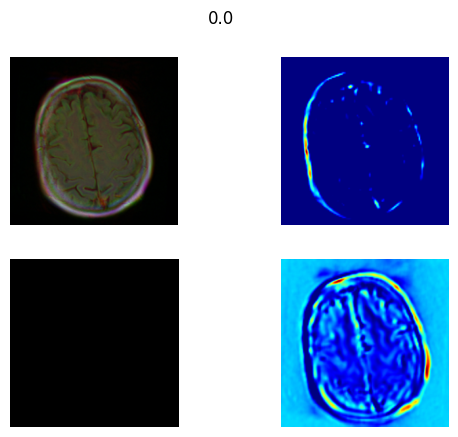

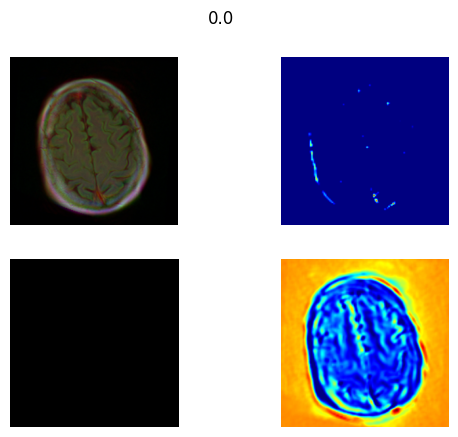

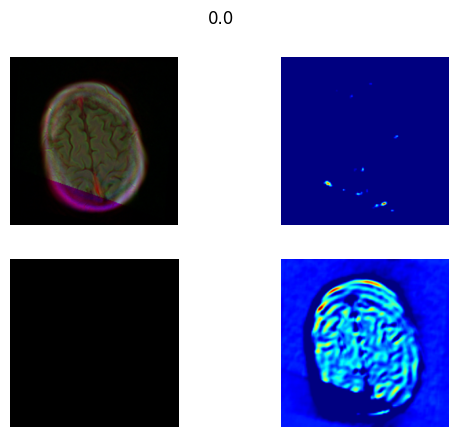

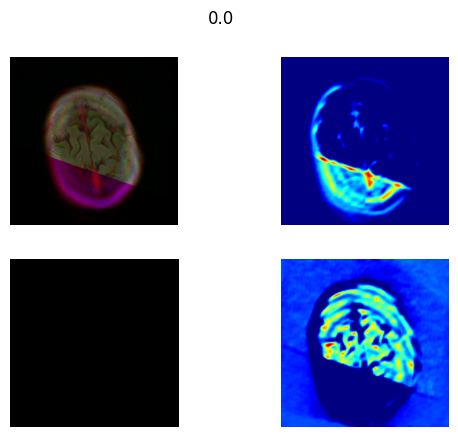

In [ ]:
for i in range(1,26):
    visualize_prediction(f'kaggle_3m/TCGA_FG_6692_20020606/TCGA_FG_6692_20020606_{i}.tif')

0.016997098922729492


100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


0.3989129066467285
0.0332489013671875


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


0.48477840423583984
0.03780841827392578


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


0.4828197956085205
0.03383803367614746


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


0.4326286315917969
0.02915358543395996


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


0.47625064849853516
0.03266572952270508


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


0.4815256595611572
0.08795619010925293


100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


0.5545871257781982
0.05317401885986328


100%|██████████| 1/1 [00:00<00:00,  1.81it/s]


0.5981338024139404
0.036870479583740234


100%|██████████| 1/1 [00:00<00:00,  1.36it/s]


0.7686433792114258
0.029678821563720703


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


0.4858663082122803
0.022532939910888672


100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


0.46094703674316406
0.039678096771240234


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


0.4599282741546631
0.036489248275756836


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


0.48011350631713867
0.02841663360595703


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


0.5039691925048828
0.0667271614074707


100%|██████████| 1/1 [00:00<00:00,  2.08it/s]


0.5370762348175049
0.03752398490905762


100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


0.47503089904785156
0.016840219497680664


100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


0.45087289810180664
0.03489828109741211


100%|██████████| 1/1 [00:00<00:00,  2.04it/s]


0.5360369682312012
0.03482341766357422


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


0.5146241188049316


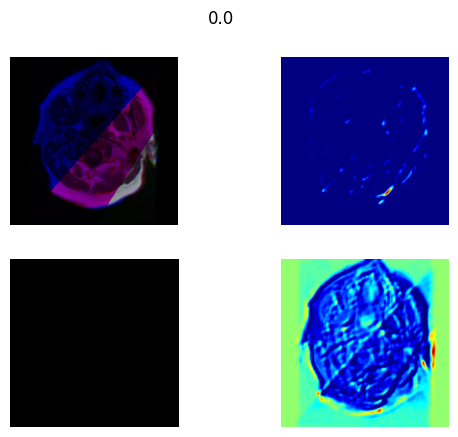

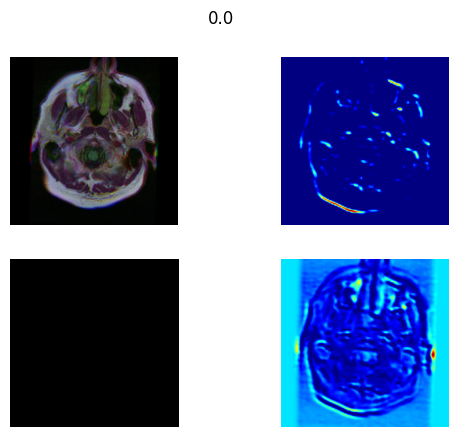

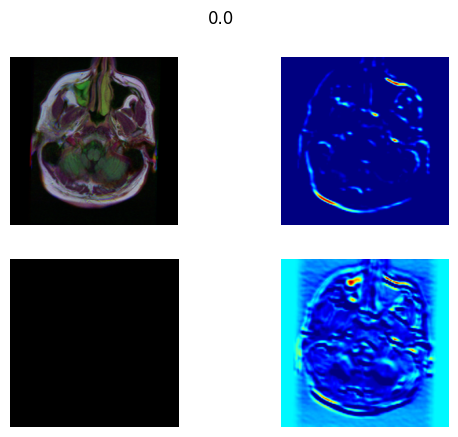

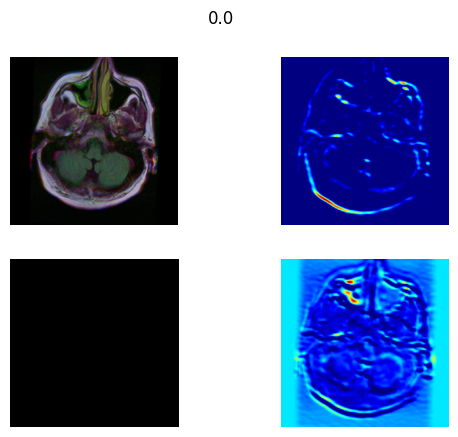

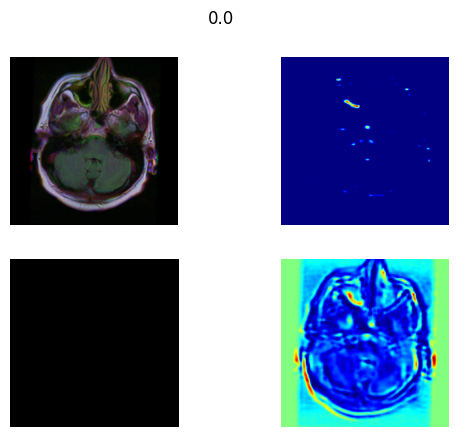

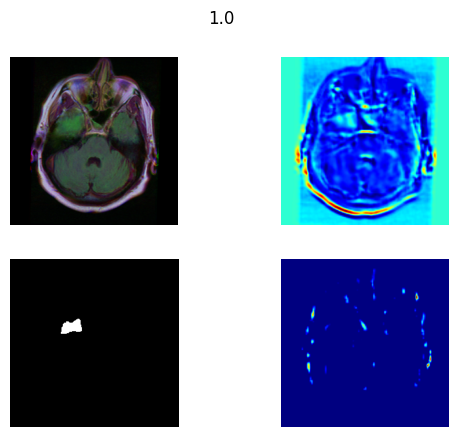

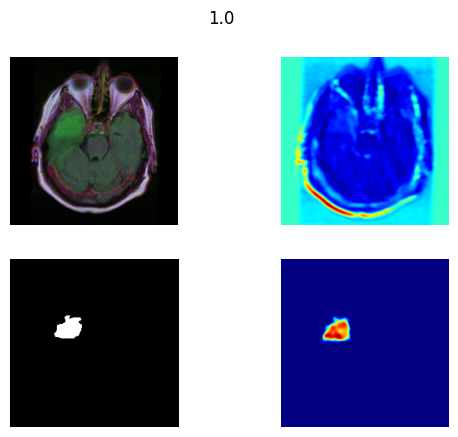

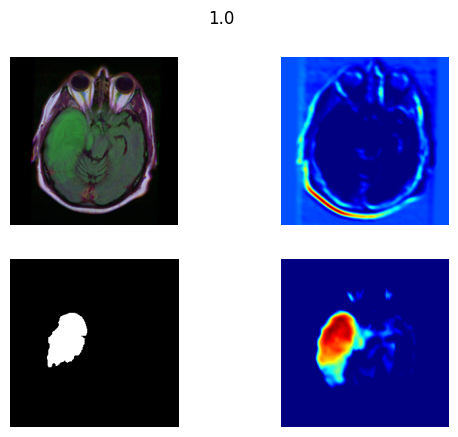

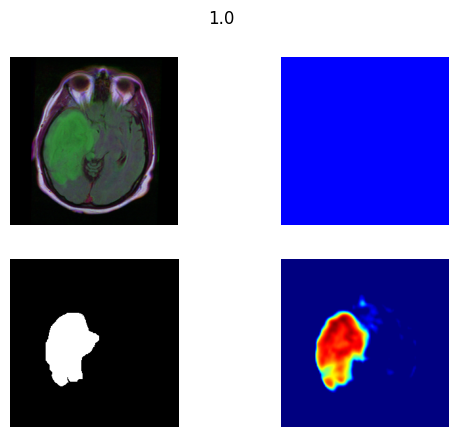

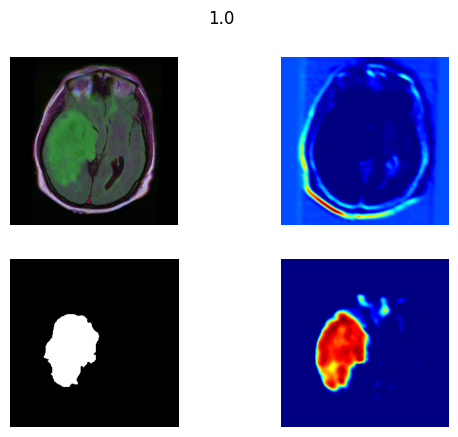

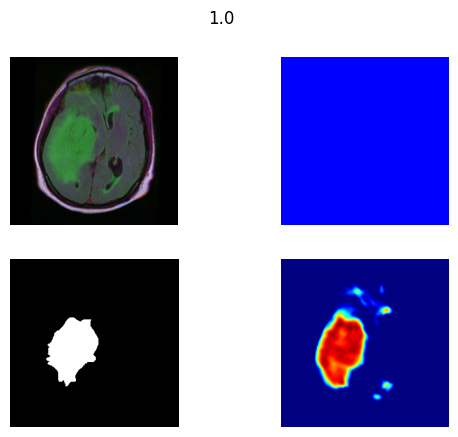

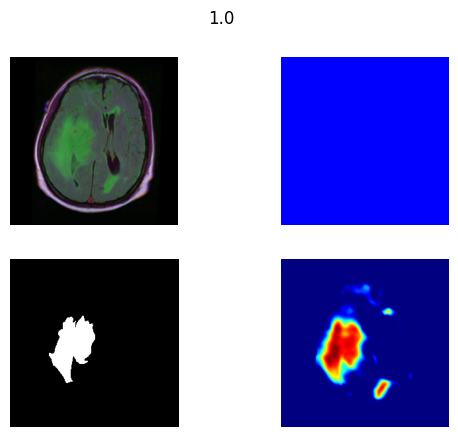

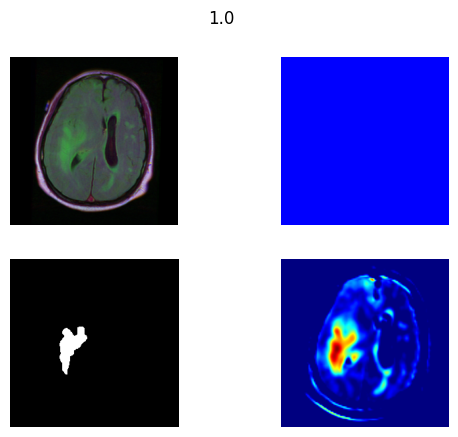

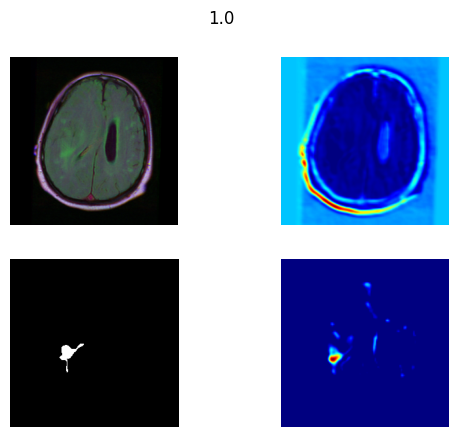

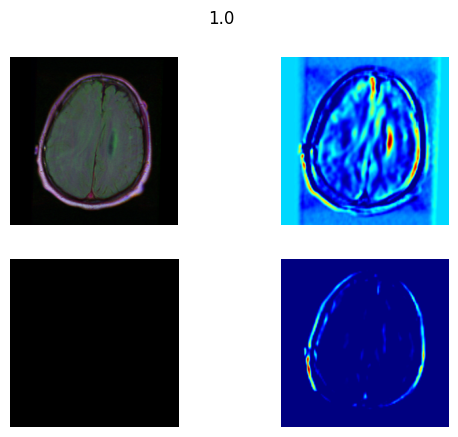

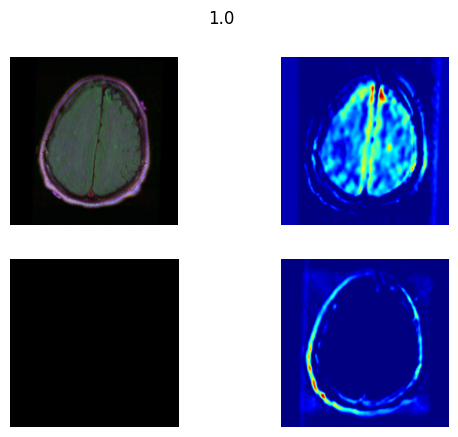

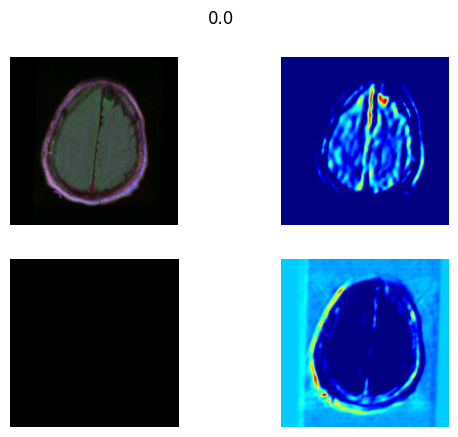

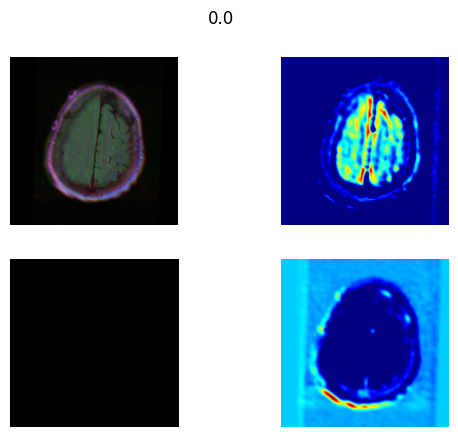

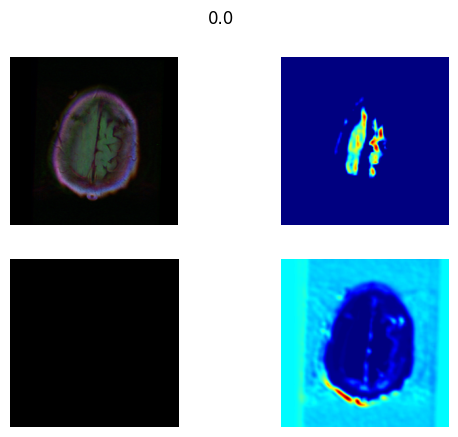

In [ ]:

for i in range(1,20):
    visualize_prediction(f'kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_{i}.tif')


Visualize Test

In [ ]:
for img in test_df['Image']:
    visualize_prediction(img)

0.02932906150817871


100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


0.4020862579345703
0.03153038024902344


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


0.494356632232666
0.01876688003540039


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


0.4665491580963135
0.016966819763183594


100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


0.4500293731689453
0.01563858985900879


100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


0.4397907257080078
0.03123307228088379


100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


0.4311943054199219
0.02515268325805664


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


0.48328495025634766
0.024248361587524414


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


0.504357099533081
0.0322110652923584


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


0.4836764335632324
0.03189373016357422


100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


0.48392629623413086
0.04263901710510254


100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


0.44448423385620117
0.029121875762939453


100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


0.4435241222381592
0.026987791061401367


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


0.48369336128234863
0.04207777976989746


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


0.5157351493835449
0.03279304504394531


100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


0.5018413066864014
0.05371713638305664


100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


0.5357463359832764
0.033463239669799805


100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


0.4559469223022461
0.0288851261138916


100%|██████████| 1/1 [00:00<00:00,  2.22it/s]


0.48331165313720703
0.03287911415100098


100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


0.4431474208831787
0.01670527458190918


100%|██████████| 1/1 [00:00<00:00,  1.67it/s]
C:\Users\roee hilel\AppData\Local\Temp\ipykernel_19336\2484463701.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax=plt.subplots(nrows=2,ncols=2)


0.6140010356903076
0.13596177101135254


100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


0.5081210136413574
0.03393411636352539


100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


0.5183968544006348
0.04491400718688965


100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


0.5832993984222412
0.030957698822021484


100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


0.45090484619140625
0.0298001766204834


100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


0.43116331100463867
0.033479928970336914


100%|██████████| 1/1 [00:00<00:00,  2.14it/s]


0.4774649143218994
0.02773761749267578


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


0.40545058250427246
0.026543855667114258


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


0.49424052238464355
0.015622377395629883


100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


0.43726611137390137
0.03850412368774414


100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


0.45040369033813477
0.0312502384185791


100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


0.3967714309692383
0.03124523162841797


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


0.41094517707824707
0.03125119209289551


100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


0.44914984703063965
0.030260324478149414


100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


0.45952916145324707
0.03028416633605957


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


0.47799205780029297
0.031002521514892578


100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


0.4357788562774658
0.0312502384185791


100%|██████████| 1/1 [00:00<00:00,  3.06it/s]


0.35827136039733887
0.03125262260437012


100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


0.3807079792022705
0.01564311981201172


100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


0.3620941638946533
0.03125166893005371


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


0.454514741897583
0.01563572883605957


100%|██████████| 1/1 [00:00<00:00,  2.13it/s]


0.5001363754272461
0.01680731773376465


100%|██████████| 1/1 [00:00<00:00,  2.00it/s]


0.5159726142883301
0.04687047004699707


100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


0.5956778526306152
0.03125643730163574


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


0.41540074348449707
0.02274012565612793


100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


0.4179878234863281
0.03305363655090332


100%|██████████| 1/1 [00:00<00:00,  2.24it/s]


0.48753905296325684
0.029265403747558594


100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


0.4478600025177002
0.03407716751098633


100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


0.49444580078125
0.02579045295715332


100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


0.47423362731933594
0.015625


100%|██████████| 1/1 [00:00<00:00,  2.35it/s]


0.45517778396606445
0.03835105895996094


100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


0.4357175827026367
0.01563239097595215


100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


0.4209096431732178
0.017558574676513672


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


0.4838712215423584
0.05247783660888672


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


0.4996931552886963
0.03826427459716797


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


0.5009512901306152
0.04868769645690918


100%|██████████| 1/1 [00:00<00:00,  2.16it/s]


0.5025384426116943
0.024100542068481445


100%|██████████| 1/1 [00:00<00:00,  2.06it/s]


0.5110034942626953
0.024907350540161133


100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


0.4042084217071533
0.0166776180267334


100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


0.4119448661804199
0.031241893768310547


100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


0.4515237808227539
0.03333401679992676


100%|██████████| 1/1 [00:00<00:00,  1.68it/s]


0.6502983570098877
0.06350445747375488


100%|██████████| 1/1 [00:00<00:00,  1.69it/s]


0.631277322769165
0.03325963020324707


100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


0.4930610656738281
0.057569265365600586


100%|██████████| 1/1 [00:00<00:00,  2.15it/s]


0.4995126724243164
0.058441162109375


100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


0.4795958995819092
0.01562786102294922


100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


0.4506692886352539
0.021310091018676758


100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


0.3858766555786133
0.039515018463134766


100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


0.38103652000427246
0.015631675720214844


100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


0.39145374298095703
0.03125619888305664


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


0.40926218032836914
0.03125762939453125


100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


0.4316256046295166
0.03330087661743164


100%|██████████| 1/1 [00:00<00:00,  1.60it/s]


0.6798958778381348
0.03427004814147949


100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


0.57753586769104
0.015025854110717773


100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


0.3961501121520996
0.020909786224365234


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


0.3969275951385498
0.02552342414855957


100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


0.3610677719116211
0.015625953674316406


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


0.3608691692352295
0.015628814697265625


100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


0.3582761287689209
0.015624046325683594


100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


0.37413930892944336
0.031229257583618164


100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


0.4200756549835205
0.03794121742248535


100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


0.4472813606262207
0.0156252384185791


100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


0.40181517601013184
0.015629053115844727


100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


0.40983128547668457
0.015635967254638672


100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


0.39351463317871094
0.03125905990600586


100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


0.38062000274658203
0.031232118606567383


100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


0.37318873405456543
0.015633106231689453


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


0.36040186882019043
0.03126931190490723


100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


0.39081501960754395
0.0156252384185791


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


0.346665620803833
0.03125286102294922


100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


0.4364480972290039
